In [1]:
%load_ext autoreload
%autoreload 2

import os
import torch
os.chdir('..')
from models.architectures.encoders.fc import HFVAEFCEncoder
from models.architectures.decoders.fc import HFVAEFCDecoder
from models.hfvae import HFVAE
from multiprocessing import cpu_count
from trainer import VAETrainer
import json
import numpy as np

print(os.getcwd())
# model parameters

INPUT_DIM = 2000
HIDDEN_DIM = 500
LATENT_DIM = 50

# training parameters
BATCH_SIZE = 500
NUM_EPOCHS = 1000
LEARNING_RATE = 5e-5
BETA1 = 0.99
EPS = 1e-9
CUDA = torch.cuda.is_available()
# beta template for hfvae (gammma, 1, alpha, beta, 0)
alpha = 1.0
beta = 7.0
gamma = 4.0
BETA = (gamma, 1.0, alpha, beta, 0.0)

DATA_PATH = 'resources/datasets/20news/'
SAVE_PATH = 'results/hfvae'



/home/dorian/FER/master_thesis/src/base


### Data loading

In [2]:
# data loading
kwargs = {'num_workers': cpu_count(), 'pin_memory': True} if CUDA else {'num_workers': cpu_count()}
labels = json.load(open(DATA_PATH+'topics.json', 'r'))
train_data = np.load(DATA_PATH+'train.npy')
train_labels = np.load(DATA_PATH+'train.labels.npy')
test_data = np.load(DATA_PATH+'test.npy')
test_labels = np.load(DATA_PATH+'test.labels.npy')


train_loader = torch.utils.data.DataLoader([[x,y] for x,y in zip(train_data, train_labels)],
                                         batch_size=BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader([[x,y] for x,y in zip(test_data, train_labels)],
                                        batch_size=BATCH_SIZE, shuffle=True, **kwargs)


### Model training

In [ ]:
# model training
enc = HFVAEFCEncoder(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM)
dec = HFVAEFCDecoder(latent_dim=LATENT_DIM, output_dim=INPUT_DIM, batch_size=BATCH_SIZE)
model = HFVAE(encoder=enc, decoder=dec, beta=BETA)
model.cuda().double()
optimizer =  torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
device = torch.device("cuda" if CUDA else "cpu")

VAETrainer(model, device, train_loader, test_loader, save_model_path=SAVE_PATH, probtorch=True, included_labels=True).run(optimizer, NUM_EPOCHS)



### Restore model

In [3]:
# EVALUATION
# model loading
enc = HFVAEFCEncoder(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM)
dec = HFVAEFCDecoder(latent_dim=LATENT_DIM, output_dim=INPUT_DIM, batch_size=BATCH_SIZE)
model = HFVAE(encoder=enc, decoder=dec)
model.load_state_dict(torch.load('results/hfvae/model_new.pt'))
model.cuda().double()
model.eval()

HFVAE(
  (encoder): HFVAEFCEncoder(
    (main): Sequential(
      (0): Linear(in_features=2000, out_features=500, bias=True)
      (1): ReLU()
    )
    (mu): Linear(in_features=500, out_features=50, bias=True)
    (logvar): Linear(in_features=500, out_features=50, bias=True)
  )
  (decoder): HFVAEFCDecoder(
    (main): Sequential(
      (0): Linear(in_features=50, out_features=2000, bias=True)
      (1): Softmax(dim=-1)
    )
  )
)

### Evaluation
#### t-SNE

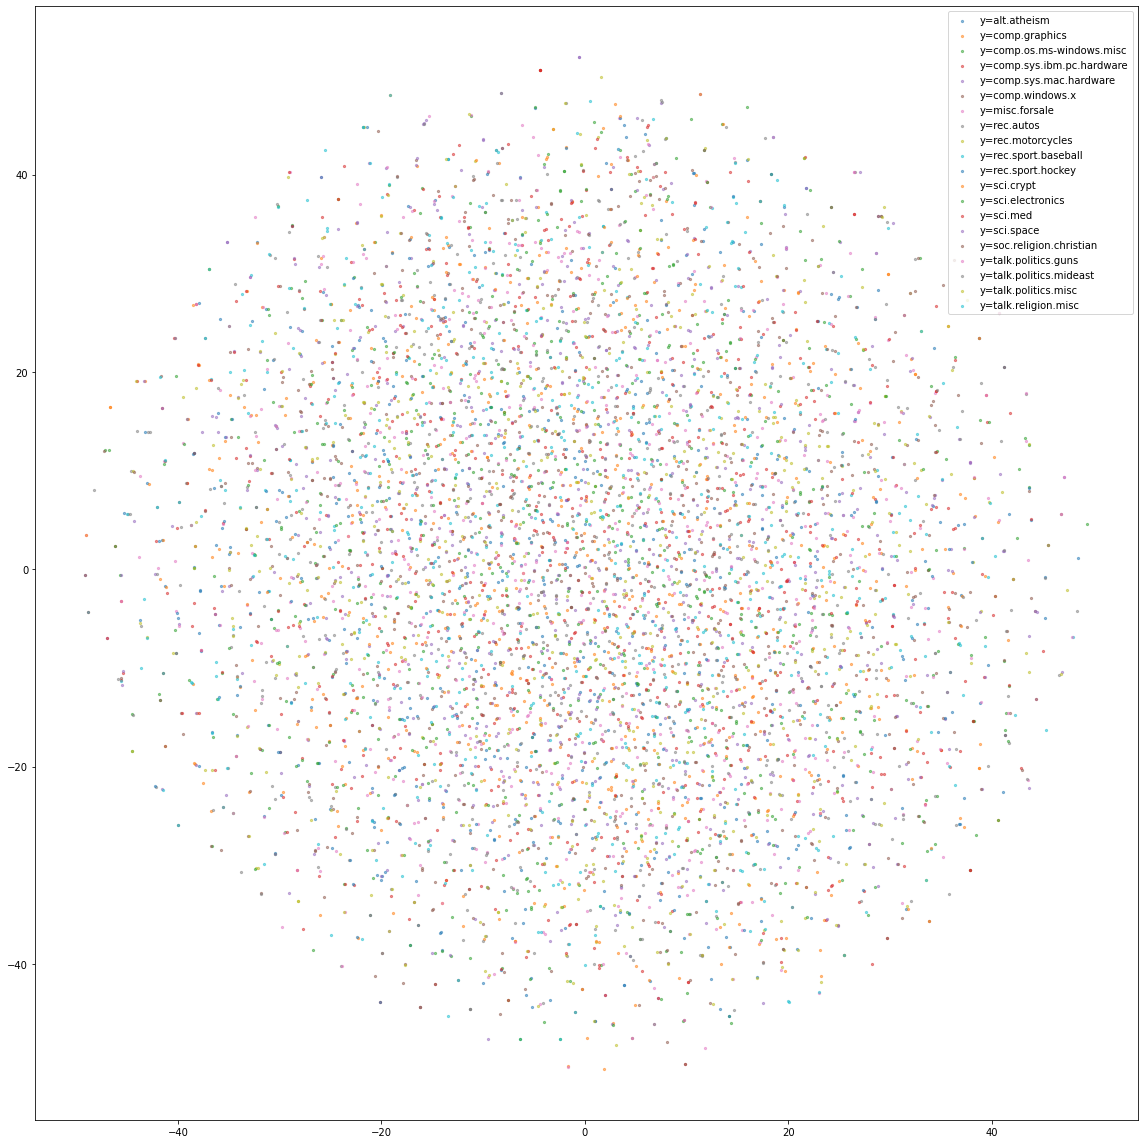

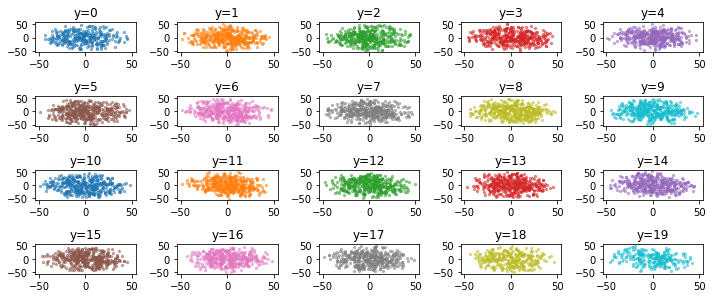

In [8]:
# Embedding visualization
# t-sne
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import numpy as np
zs = []
z_mus = []
xs = []
ys = []

for (x, y) in test_loader:
    if len(x) == BATCH_SIZE:
        q = model.encode(x.cuda())
        z = q['z'].value.cpu().detach().numpy()
        mu = q['z'].dist.loc.cpu().detach().numpy()
        zs.append(z.reshape(-1, LATENT_DIM))
        z_mus.append(mu.reshape(-1, LATENT_DIM))
        xs.append(x.numpy())
        ys.append(y.numpy())

zs = np.concatenate(zs, 0)
z_mus = np.concatenate(z_mus, 0)
xs = np.concatenate(xs, 0)
ys = np.concatenate(ys, 0)
zs_mean = zs.mean(0)
zs_std = zs.std(0)

%matplotlib inline
zs2 = TSNE().fit_transform(zs)

fig = plt.figure(figsize=(16,16))
ax = plt.gca()

colors = []
for k in range(len(labels)):
    m = (ys==k)
    p = ax.scatter(zs2[m, 0], zs2[m, 1], label='y=%s'%labels[k], alpha=0.5, s=5)
    colors.append(p.get_facecolor())
ax.legend()
fig.tight_layout()
x_lim = ax.get_xlim()
y_lim = ax.get_ylim()

# for each class independently
fig = plt.figure(figsize=(10,4.25))

for k in range(len(labels)):
    ax = plt.subplot(4,5,k+1)
    m = (ys == k)
    ax.scatter(zs2[m, 0], zs2[m, 1], alpha=0.5, s=5, c=colors[k])
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.set_title('y=%d' % k)

fig.tight_layout()


#### Correlation plot (z)

In [ ]:
#correlation plot
import seaborn as sn
cov_matrix = np.cov(z_mus)
sn.heatmap(cov_matrix, annot=True, fmt='g')
plt.title('Z correlations')
plt.colorbar()
plt.show()


#### Top words

In [4]:
from evaluation.topics import print_top_words
# Top words in topics
# load the vocab
vocab = json.load(open(DATA_PATH+'vocab.json','r'))
idx2word = {i:vocab[i] for i in range(len(vocab))}
# get weights of the decoder
emb = model.decoder.main[0].weight.cpu().detach().numpy().T
print_top_words(emb, idx2word)


--------------- Topics ------------------
nsa modes chip intelligence values existence evidence clipper gods atheist
young town drugs home bodies children hospital insurance parents hall
mouse motif event events scripture widget teaching server background doug
phone police switch auto insurance signal private safe single block
colors serdar argic square york armenians display won green blue
win vga mode constitution default processor switch clock character scsi
human life death rights driving laws live case muslim muslims
max israel light israeli gas armenia thousands soldiers bank solar
word problem american canada baseball game science players home talk
window windows installed switch install mode installation user manual standard
batf koresh compound life meaning destroy followers chapter printing mary
drive mechanism data system floppy ram bus drives street isa
van commercial mit computing files warrant search scott encryption andrew
defense board transfer ide speed space seconds l

#### NPMI

In [7]:
from evaluation.topics import npmi_coherence_score
import pickle
X_raw = json.load(open(DATA_PATH+'X_raw.json','r'))
decoder_weight = model.decoder.main[0].weight.detach().cpu()
top_words = 10
topics = [
    [idx2word[item.item()] for item in topic]
    for topic in decoder_weight.topk(10, dim=0)[1].t()
]
word_frequencies = pickle.load(open(DATA_PATH+'word_frequencies.pkl','rb'))
joint_word_frequencies = pickle.load(open(DATA_PATH+'jointword_frequencies.pkl','rb'))
npmi_per_topic = npmi_coherence_score(topics, word_frequencies, joint_word_frequencies)
print(npmi_per_topic)
print(sum(npmi_per_topic)/len(npmi_per_topic))
print('Max: %f'%max(npmi_per_topic))
print('Topic : %s'%(' '.join(topics[np.argmax(npmi_per_topic)])))

# Note - papers didn't report the normalized value

[0.06217287488263861, 0.26473767874838317, 0.1258141693752434, 0.17529207065582272, 0.12606464716955318, 0.11575843523054809, 0.2637133687632727, 0.10590849168121626, 0.15267466080771325, 0.3130522685079343, 0.14468064646439002, 0.27048679846499746, 0.24938150282060104, 0.0763699240772836, 0.2938990864065716, 0.11972831724867569, -0.30012140113408564, 0.16874915140242785, 0.3010576633974214, 0.18295353253011934, 0.20659631942357476, 0.3757738835964452, 0.2501274436550629, 0.20225503980939427, 0.2611391073115599, -0.015003401737502661, 0.3137521926565342, 0.23826768169097473, 0.1854799567252847, 0.2801482299066621, 0.3378903949581857, -0.053859659467406236, 0.1581944338276684, 0.16667336950204223, 0.18594367606541667, 0.07673988072092851, 0.043016078851931025, 0.2240966952575835, 0.06396853696285924, 0.22132595346372066, 0.18703779685940602, 0.185883027223162, 0.096774073608489, 0.2012315534790331, 0.09840478612514675, -0.12919870649966367, 0.5158796337398839, 0.23543566156565968, 0.229

#### LDA for comparison

In [18]:
import gensim
# training classic LDA just for comparison
corpus = gensim.matutils.Dense2Corpus(train_data, documents_columns=False)
lda = gensim.models.LdaMulticore(corpus=corpus,
                                 id2word=idx2word,
                                 num_topics=50,
                                 random_state=100,
                                 passes=10)

In [19]:
coherence_model = gensim.models.CoherenceModel(model=lda,
                                               texts=X_raw,
                                               dictionary=gensim.corpora.dictionary.Dictionary.from_corpus(corpus, idx2word),
                                               coherence='c_npmi')
topic_coherences = coherence_model.get_coherence_per_topic()
print(topic_coherences)
print(sum(topic_coherences)/len(topic_coherences))

[0.05049653446593177, 0.018853839167305892, 0.13889612641516624, 0.022945950029298473, -0.0006003120676231906, 0.1428051110383231, 0.11315420450649968, 0.0603837412866034, -0.07631427244884832, 0.13477647813050067, -0.12113910056456596, 0.03452064847060468, -0.012526820374331515, 0.13433586922156424, 0.08481460233152115, -0.0046095948153488525, 0.14795521458271274, 0.0643200487789307, 0.09741848749268073, -0.028582443389426147, 0.013560249247074262, -0.029854817229828124, 0.17069680278113172, 0.041594051846695755, 0.023262740152461197, -0.015284992085027458, 0.02957366350989352, -0.012382081119426134, -0.0809209396639903, -0.05902062671151506, -0.03754023400933772, 0.054073430455275046, 0.044970844029611955, 0.004594873432606471, 0.11843654659168892, 0.05827839243050851, -0.12443164045021132, 0.018179347383259856, -0.06328050309834121, 0.003220650621897766, 0.018718541240538306, -0.009209533430282583, 0.09513379877887652, 0.16329721392069838, 0.024118672311393214, -0.06975283708929722,

In [21]:
# with my implementation
topics = lda.show_topics(num_topics=50, num_words=10, formatted=False)
topics = [[t[0] for t in topic[1]] for topic in topics]
npmi_per_topic = npmi_coherence_score(topics, word_frequencies, joint_word_frequencies)
print(npmi_per_topic)
print(sum(npmi_per_topic)/len(npmi_per_topic))
for topic in topics:
    print(topic)

[0.16410033369830448, 0.3111506547532112, 0.3114129065896065, 0.2532044613857142, 0.18540062448569977, 0.3571823886854365, 0.3122368409907439, 0.2697089955510378, 0.14553792552260353, 0.416451331905533, 0.19892567161221894, 0.27745537742764353, 0.20559272753652633, 0.340324700723863, 0.4240882933319373, 0.22213953829759964, 0.4676971884705831, 0.13982192371931396, 0.3665607427566965, 0.18697436442110582, 0.32289840459720787, 0.24979912838610635, 0.3740518835592937, 0.21790243274365118, 0.21180207632988513, 0.20816621490125248, 0.18736735069409186, 0.17593497473809364, 0.17990350537115046, 0.18011868130999345, 0.23890330528870785, 0.237629458728827, 0.16311259013485555, 0.16870227815922761, 0.3344769660198739, 0.23457751758471912, 0.15180438273571348, 0.17458782640347076, 0.1379065730339304, 0.28150057621561597, 0.1909182071256871, 0.28186802094285945, 0.26290095125736423, 0.4331352499031874, 0.15669152368152559, 0.14540524721734785, 0.18392229075549102, 0.14442045864007083, 0.121592459

#### Mutual informtaion - I(x,zd)

In [ ]:
# mutual information
from evaluation.NPEET.npeet import entropy_estimators as ee
import warnings
warnings.filterwarnings("ignore")
# i don't know if this is right but it works
# mi = ee.mi(xs, zs)
# this one also works
mis = []
for i in range(1):
    mi = ee.mi(zs[:, i].reshape(-1, 1), xs)
    print(mi)
    mis.append(mi)
print(mis)
# mis = [ee.mi(zs[:, i].reshape(-1, 1), xs) for i in range (zs.shape[1])]
# print(sorted(mis))

#### Mutual information - I(yk,zd)